In [1]:
import ROOT

Welcome to JupyROOT 6.12/06


#### Open MonteCarlo files

These files were generated using `Madgraph5_aMC@NLO` showered with `Pythia8` and simulated with `Delphes`.

This sounds very complicated but with a nominal setup of mg5 from [here](https://launchpad.net/mg5amcnlo), taking a moment to run `install pythia8` and `install Delphes`, and running the following commands will produce similar events.

```
import model heft

generate p p > h, h > a a
output Hgg_RUN
launch Hgg_RUN
generate p p > a a / h 
output HggBackground_RUN
launch HggBackground_RUN
```

To further simplify matters however the resulting root files are slimmed of most of their branches (Taus, FatJets etc) such that the few branches that remain don't need any additional classes to read. Additional information can be found [here](https://twiki.cern.ch/twiki/bin/view/Main/UnitsHiggsTutorial2016)

In [2]:
sig_file = ROOT.TFile.Open("HggSignal.root")
signal_tree = sig_file.Get("Tree")
bkg_file = ROOT.TFile.Open("HggBackground.root")
background_tree = bkg_file.Get("Tree")

In [3]:
lumi = 25000

#### Define Histograms

In [4]:
mgg = ROOT.TH1F("mgg","di photon mass",60,100,160)
mgg_background = ROOT.TH1F("mgg_background","background di photon mass",60,100,160)

#### Define an Event Selection

for each tree we assert that there must be at least two photons, no leptons and the scalar sum of objects in the region must be larger than 100 GeV

further more we assert that the highest $p_\mathrm{T}$ photon has at least 40 GeV of transverse energy and the next highest 30 GeV.

The isolation variable shows how far the energy clusters of the photon candidate are distributed about the mean. 

In [5]:
def apply_cuts(tree, histogram):
    for event in tree:
        if event.n_photons >1 and event.n_leptons < 1:# and event.ht > 0.:
            lead = ROOT.TLorentzVector(event.gamma_lead_pt,event.gamma_lead_eta,event.gamma_lead_phi,0.)
            sublead = ROOT.TLorentzVector(event.gamma_sublead_pt,event.gamma_sublead_eta,event.gamma_sublead_phi,0.)
            di_photon = lead + sublead        
            if lead.Pt()> 40 and sublead.Pt()>30 and event.lead_isolation < 0.04 and event.sublead_isolation < 0.04:
                histogram.Fill(abs(di_photon.M()),event.weight*lumi)
    return histogram

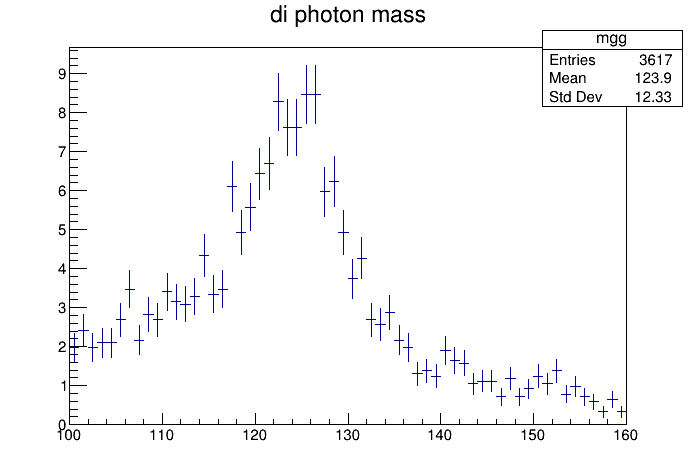

In [6]:
mgg = apply_cuts(signal_tree, mgg)
c1 = ROOT.TCanvas()
mgg.Draw()
c1.Draw()

As can be seen, the application of cuts convolutes the shape of the distribution and the number of events produced by the MonteCarlo can have a large effect on the overall uncertainty

 FCN=74.0656 FROM MIGRAD    STATUS=CONVERGED      60 CALLS          61 TOTAL
                     EDM=3.62822e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     9.14752e+00   5.71615e-02   3.20654e-05  -6.86412e-03
   2  Slope       -2.41771e-02   4.60612e-04   2.58387e-07  -6.97871e-01


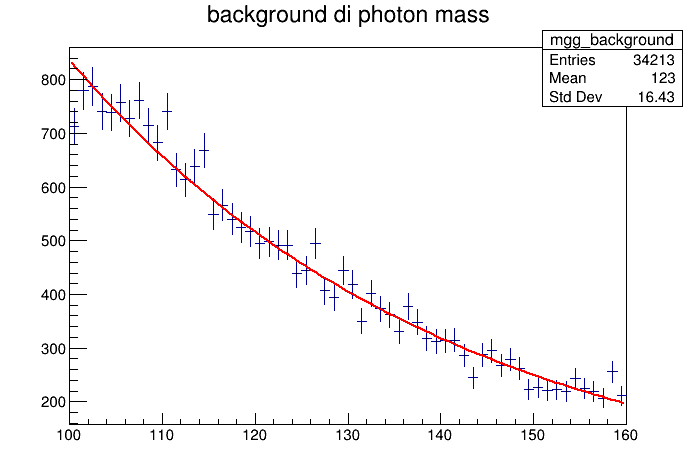

In [7]:
mgg_background = apply_cuts(background_tree, mgg_background)
c1 = ROOT.TCanvas()
mgg_background.Draw()
fitResultPtr = mgg_background.Fit("expo","S")
c1.Draw()

#### Validate the background shape

In the above stage we assert that the background distribution form a exponential distribution.

We now validate (by eye) that the binning and distribution are sufficient for our needs. 

In this case we scale the signal histogram by 5 to make it more visible. 

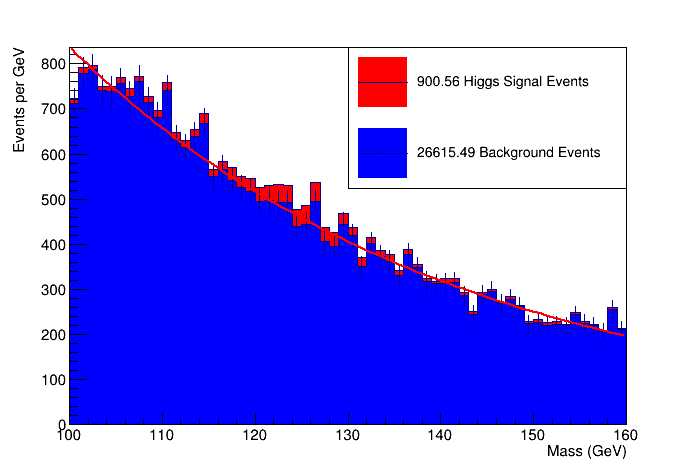

In [8]:
ROOT.gStyle.SetOptStat(0)
mgg.SetFillColor(2)
mgg.SetStats(0)
mgg.Scale(5)
mgg_background.SetFillColor(4)
mgg_background.SetStats(0)
leg = ROOT.TLegend(0.5,0.6,0.9,0.9)
leg.AddEntry(mgg,"{:.2f} Higgs Signal Events".format(mgg.Integral()))
leg.AddEntry(mgg_background,"{:.2f} Background Events".format(mgg_background.Integral()))
stack = ROOT.THStack()
stack.Add(mgg_background)
stack.Add(mgg)
stack.Draw("HIST")
mgg_background.Draw("same")
leg.Draw()
stack.GetXaxis().SetTitle("Mass (GeV)")
stack.GetYaxis().SetTitle("Events per GeV")
c1.Draw()

#### Prepare Workspace

First we convert the histograms into histogram pdf objects. 

Our range is the Mass range plotted above.

In [9]:
x = ROOT.RooRealVar("x","x",100,160)
l = ROOT.RooArgList(x)


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [10]:
signalhist = ROOT.RooDataHist("sighist", "sighist", l, mgg)
sigpdf = ROOT.RooHistPdf("sigpdf","sigpdf",ROOT.RooArgSet(x),signalhist,0)
bkghist = ROOT.RooDataHist("bkghist", "bkghist", l, mgg_background)
bkgpdf = ROOT.RooHistPdf("bkgpdf","bkgpdf",ROOT.RooArgSet(x),bkghist,0)

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(sighist): fit range of variable x expanded to nearest bin boundaries: [100,160] --> [100,160]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(bkghist): fit range of variable x expanded to nearest bin boundaries: [100,160] --> [100,160]


In [11]:
fsig = mgg.Integral()/(mgg.Integral()+mgg_background.Integral())
print fsig

0.0327285539026


#### Create a composite model signal+background (gauss+bkg)

In [12]:
mean = ROOT.RooRealVar("mean","Mean of Gaussian",120,100,160)
sigma = ROOT.RooRealVar("sigma","Width of Gaussian",5,0,10)
hgammagamma = ROOT.RooGaussian("Hgammagamma","Gaussian with mean",x,mean,sigma)

In [13]:
hgammagamma.fitTo(signalhist,ROOT.RooFit.Range(118,132),ROOT.RooFit.PrintLevel(-1))

<ROOT.RooFitResult object at 0x(nil)>

[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(Hgammagamma) WARNING: a likelihood fit is request of what appears to be weighted data. 
       While the estimated values of the parameters will always be calculated taking the weights into account, 
       there are multiple ways to estimate the errors on these parameter values. You are advised to make an 
       explicit choice on the error calculation: 
           - Either provide SumW2Error(kTRUE), to calculate a sum-of-weights corrected HESSE error matrix 
             (error will be proportional to the number of events)
           - Or provide SumW2Error(kFALSE), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights)
       If you want the errors to reflect the information contained in the provided dataset, choose kTRUE. 
       If you want the errors to reflect the precision you would be able to obtain with an unweighted dataset 
       with 'sum-of-weights' events, cho

[#1] INFO:InputArguments -- RooAbsData::plotOn(sighist) INFO: dataset has non-integer weights, auto-selecting SumW2 errors instead of Poisson errors
[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) p.d.f was fitted in range and no explicit plot,norm range was specified, using fit range as default
[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) only plotting range 'fit_nll_Hgammagamma_sighist'
[#1] INFO:Plotting -- RooAbsPdf::plotOn(Hgammagamma) p.d.f. curve is normalized using explicit choice of ranges 'fit_nll_Hgammagamma_sighist'


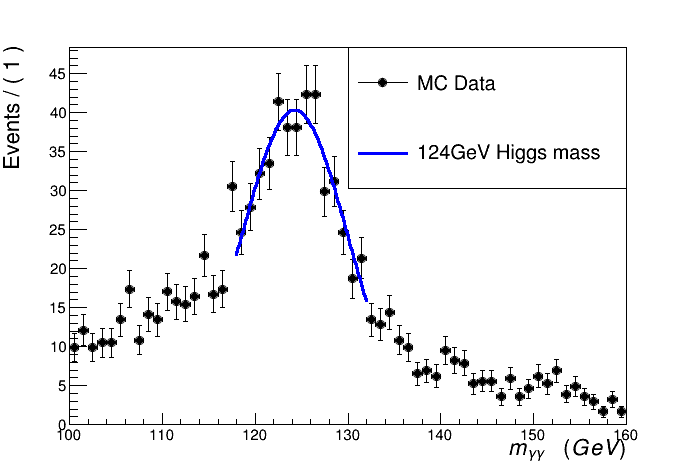

In [14]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Signal Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleOffset(.6)
plot.SetXTitle(r"$m_{\gamma\gamma}$ (GeV)")
signalhist.plotOn(plot,ROOT.RooFit.Name("data"))
hgammagamma.plotOn(plot,ROOT.RooFit.Name("hgg"))

l = ROOT.TLegend( 0.5, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
hobj = plot.findObject("hgg")

l.AddEntry( dataobj , "MC Data", "pl" )
l.AddEntry( hobj , "{0:0.0f}GeV Higgs mass ".format(mean.getVal()), "l"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

In [15]:
sigma.getVal()

5.662231686496792

##### and repeat for Background`

In [16]:
lamb = ROOT.RooRealVar("lambda","Decay rate of exponential",-1,-2,0)
nonhiggs = ROOT.RooExponential("continuum","Exponential",x,lamb)

In [17]:
nonhiggs.fitTo(bkghist,ROOT.RooFit.Range(100,160),ROOT.RooFit.PrintLevel(-1))

<ROOT.RooFitResult object at 0x(nil)>

[#0] WARNING:InputArguments -- RooAbsPdf::fitTo(continuum) WARNING: a likelihood fit is request of what appears to be weighted data. 
       While the estimated values of the parameters will always be calculated taking the weights into account, 
       there are multiple ways to estimate the errors on these parameter values. You are advised to make an 
       explicit choice on the error calculation: 
           - Either provide SumW2Error(kTRUE), to calculate a sum-of-weights corrected HESSE error matrix 
             (error will be proportional to the number of events)
           - Or provide SumW2Error(kFALSE), to return errors from original HESSE error matrix
             (which will be proportional to the sum of the weights)
       If you want the errors to reflect the information contained in the provided dataset, choose kTRUE. 
       If you want the errors to reflect the precision you would be able to obtain with an unweighted dataset 
       with 'sum-of-weights' events, choos

[#1] INFO:InputArguments -- RooAbsData::plotOn(bkghist) INFO: dataset has non-integer weights, auto-selecting SumW2 errors instead of Poisson errors
[#1] INFO:Plotting -- RooAbsPdf::plotOn(continuum) p.d.f was fitted in range and no explicit plot,norm range was specified, using fit range as default
[#1] INFO:Plotting -- RooAbsPdf::plotOn(continuum) only plotting range 'fit_nll_continuum_bkghist'
[#1] INFO:Plotting -- RooAbsPdf::plotOn(continuum) p.d.f. curve is normalized using explicit choice of ranges 'fit_nll_continuum_bkghist'


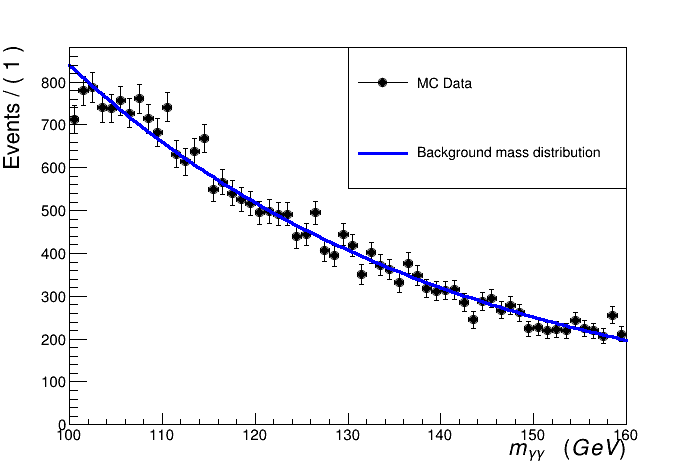

In [18]:
c = ROOT.TCanvas()
plot = x.frame(ROOT.RooFit.Title("Background Mass"))
plot.SetTitle("")
plot.GetYaxis().SetTitleOffset(1.)
plot.GetYaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleSize(0.05)
plot.GetXaxis().SetTitleOffset(.6)
plot.SetXTitle(r"$m_{\gamma\gamma}$ (GeV)")
bkghist.plotOn(plot,ROOT.RooFit.Name("data"))
nonhiggs.plotOn(plot,ROOT.RooFit.Name("QCD"))

l = ROOT.TLegend( 0.5, 0.6, 0.9, 0.9)
dataobj = plot.findObject("data")
bobj = plot.findObject("QCD")

l.AddEntry( dataobj , "MC Data", "pl" )
l.AddEntry( bobj , "Background mass distribution", "l"  )
l.SetTextSizePixels(400)
plot.Draw()
l.Draw()
c.Draw()

#### and combine into a single model

In [19]:
fsig = ROOT.RooRealVar("fsig","signal fraction",fsig,0.,1.)

model = ROOT.RooAddPdf("model","model",ROOT.RooArgList(hgammagamma,nonhiggs),ROOT.RooArgList(fsig))

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (continuum)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


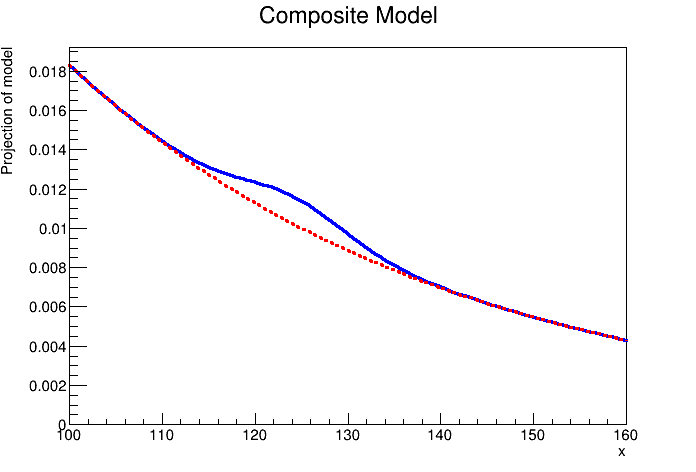

In [20]:
c1 = ROOT.TCanvas()
xframe = x.frame(ROOT.RooFit.Title("Composite Model"))
model.plotOn(xframe)
bkg_component = ROOT.RooArgSet(nonhiggs)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1.Draw()

#### and now import all the models into the workspace

In [21]:
w = ROOT.RooWorkspace("w")
getattr(w,'import')(sigpdf)
getattr(w,'import')(bkgpdf)
getattr(w,'import')(model)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset sighist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::sigpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::x
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset bkghist
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooHistPdf::bkgpdf
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooAddPdf::model
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooGaussian::Hgammagamma
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::mean
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::sigma
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::fsig
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooExponential::continuum
[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing RooRealVar::lambda


#### generating data from model

In [22]:
datamodel = ROOT.RooAddPdf("datamodel","datamodel",ROOT.RooArgList(sigpdf,bkgpdf),ROOT.RooArgList(fsig))
data = datamodel.generate(ROOT.RooArgSet(x),10000)

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (continuum)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (Hgammagamma)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


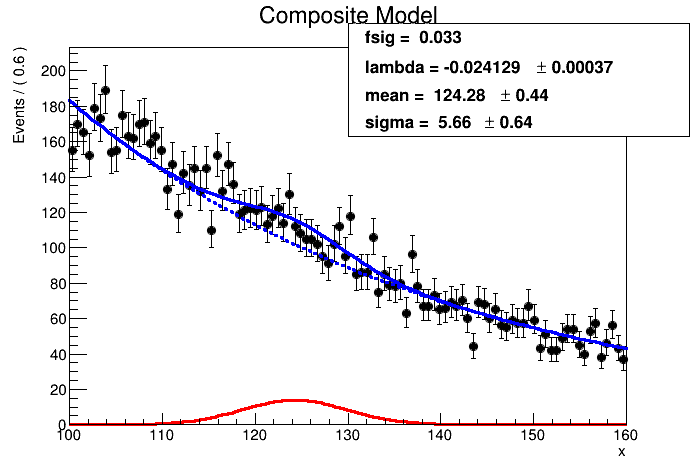

In [23]:
c1 = ROOT.TCanvas()
xframe = x.frame(ROOT.RooFit.Title("Composite Model"))
data.plotOn(xframe)
model.plotOn(xframe)
model.paramOn(xframe)
bkg_component = ROOT.RooArgSet(nonhiggs)
sig_component = ROOT.RooArgSet(hgammagamma)
model.plotOn(xframe,ROOT.RooFit.Components(bkg_component),ROOT.RooFit.LineStyle(2))
model.plotOn(xframe,ROOT.RooFit.Components(sig_component),ROOT.RooFit.LineColor(2))
xframe.Draw()
c1.Draw()

In [24]:
getattr(w,'import')(data)

False

[#1] INFO:ObjectHandling -- RooWorkspace::import(w) importing dataset wu


#### Set the Model Configuration and Save

In [25]:
mc = ROOT.RooStats.ModelConfig("ModelConfig",w)
mc.SetPdf(model)
mc.SetParametersOfInterest(ROOT.RooArgSet(w.var("fsig")))
mc.SetObservables(ROOT.RooArgSet(w.var("x")))
getattr(w,'import')(mc)

False

In [26]:
w.writeToFile("HgammagammaWS.root",True)

False

In [27]:
### Background only 